# Tutorial #2: How to query data from BigQuery in a Notebook

Welcome to part II of our tutorials designed for participants in the IronHacks. In this second notebook (part II), we will show you how you can access our training data stored in BigQuery using a key stored in your user profile.

> Before you get started: This tutorial will not more 10 min and you should be able to work with our training data right after. 

**Our goal**: Help you getting started with the R packages `BigRQuery` or `DBI` or `dply` in order to access a training dataset stored in BigQuery! So if you have never used these libraries before this tutorial is key for you. 

**BigQuery - What's that?**: 
BigQuery is Google's flagship data warehousing system: "Serverless, highly scalable, and cost-effective multi-cloud data warehouse designed for business agility". It allows you to analyze large amount of data using ANSI SQL at blazing-fast speeds, with zero operational overhead. You can find out more [here](https://cloud.google.com/bigquery). 


**Why do we use BigQuery?**
In the COVID-19 Data Science Challenges you will use BIG DATA from our data providers SafeGraph, the Management Performance Hub (MPH), and other partners (Department of Workforce Development). The first hack Summer 2020, will use preprocessed data so you will not need to use all the functionalities of BIG QUERY as we have sampled down more than 50 datasets with more than 1 TB and millions of raws into a small sets of cleaned tables without missing entries and clear identifiers. However, using BigQuery will still be very helpful as you can see for exploring data without having to use them in memory etc. It will also set you up for the future of data science since BigQuery is replacing other BIG DATA services (e.g. Spark). 

**How do we give you access to BigQuery?**
In Big Query data are stored in projects. Inside a project there are multiple datasets. Each dataset can contain multiple tables. 
In this hack we give you access to a project called: `ironhacks-covid19-data`. In this project there are two datasets:`ironhacks-covid19-data:ironhacks_covid19_training` and `ironhacks-covid19-data:ironhacks_covid19_competition
`. During the training period you will only find data in the first dataset. In this first tutorial we only use one first relatively simply structured table stored in this dataset. It is called `covid19_tests_cases_deaths_IN`

> Keep in mind: In this tutorial you will learn how to get access to the `ironhacks-covid19-data` and the datset `ironhacks-covid19-data:ironhacks_covid19_training` stored inside this project.

**What's BigRQuery?**: 
`BigRQuery` package allows you to query data stored in BigQuery You can find the official documentation [here](https://bigrquery.r-dbi.org/)

**What's DBI?**
The `DBI` package helps connecting R to database management systems (DBMS). `DBI` separates the connectivity to the DBMS into a “front-end” and a “back-end”. It defines an interface that is implemented by the "backend". In our case the backend is BigRQuery (but it also uses other backends such as SQLlite etc.). You can find the official documentation [here](https://dbi.r-dbi.org/) 

**What's dplry?**
`dplry` is is a grammar of data manipulation, providing a consistent set of verbs that help you solve the most common data manipulation challenges. It is part of the `tidyverse` package. You can find the official documentation [here](https://dplyr.tidyverse.org/) The `dplyr` interface lets you treat BigQuery tables as if they are in-memory data frames. This is the most convenient layer if you don’t want to write SQL, but instead want dbplyr to perform SQL queries in the background.

> the following tutorial is structured in four section! So let's get started! 

## Section I: Loading the libraries

In a first step, we will be loading the libraries we need. I load the complete tidyverse package in case I want to also plot later but you can also just load dplyr

In [59]:
lapply (c("bigrquery","tidyverse","DBI"),require, character.only=TRUE) ###loading the libraries I need

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

> As mentioned in part 1 of our tutorial, there is no installation required for you. So this should do the job very fast for you. 

## Section II: Authorizing your BigQuery Access

1. Getting your key
2. Setting up the autorization
3. And finding out more what you can do with this key!

So the next step now is to find the keys: 1) Go to your user profile, 2) click on *Download your hack dataset training key* and 3) Upload it to your Juptyer lab environment. Below you find a screenshot where you can find your key. 

![image](https://raw.githubusercontent.com/ironhacks/Tutorials-COVID-19/master/part-2/profile_image.jpg?token=AC7DAY5X2TFRU6J6IU7ZQ5S7FXKP2)

> After you have added the key to your file structure in your lab environment you can authorize your access! 

In [60]:
bq_auth(path = "/home/jovyan/Tutorials/service-account.json") #authorizing the token! 

> **This is an important step***: please keep in mind that you need to put the path `/home/jovyan/` followed by your directory name and the name that you give to your json file! 

In [61]:
bq_has_token() #confirms that bq has token

[1] TRUE

> **Yeah it is working!**

In [62]:
bq_projects(page_size = 10, max_pages = 1, warn = TRUE) # now I am getting the projects that are associated with that token! Yeah - it is the right one.

[1] "ironhacks-covid19-data"

In [63]:
bq_project_datasets('ironhacks-covid19-data', page_size = 10, max_pages = 1, warn = TRUE) # now you also see the datasets in the project 

[[1]]
<bq_dataset> ironhacks-covid19-data.ironhacks_covid19_competition

[[2]]
<bq_dataset> ironhacks-covid19-data.ironhacks_covid19_training


**Next** we are establishing the database connection! 

In [64]:
projectid<-'ironhacks-covid19-data'
datasetid<-'ironhacks_covid19_training'
bq_conn <-  DBI::dbConnect(bigquery(), 
                            project = projectid,
                            dataset = datasetid,
                            use_legacy_sql = FALSE
                      ) ## setting up the project and the database connection

In [65]:
DBI::dbListTables(bq_conn) ##checking the tables in there! 

[1] "covid19_tests_cases_deaths_IN"

> Yeah! Now we have what we need to move on! We have also prepared a sheet with the schema of the database so that it is easier for you to understand what is in there. It can be found [here](https://docs.google.com/spreadsheets/d/1s591Ajha7KJMM0syot0Nc3fRRgEaT8zIU4BCPKeyEzk/edit#gid=557548514). 

## Section III: Loading, understanding, and querying table with dplr() wihout using SQL directly
So what we do: 
* Using 'dplyr' to load the table and understanding it WITHOUT loading into memory using pipes `%>%` and `summarize()` 
* Querying the table with `dplr` to select the variables `DATE`,`COVID_TEST`,`COVID_COUNT` with the `select()` function, filtering for period `2020-04-01` to `2020-05-01` using the `filter()`function, and summarizing it using `summarize()` - all without loading it into memory
* Plotting the query with ggplot() without loading into memory
* Eventually loading it into memory as a tibble...

The table `covid19_tests_cases_deaths_IN` can be easily accessed by using the dplyr::tbl() function and passing the table name and BigQuery connection details as parameters. We will do this next

In [66]:
table<-dplyr::tbl(bq_conn,'covid19_tests_cases_deaths_IN')

Notice that the “table” is of class tbl_sql and not a tibble. This is because tbl() creates a direct reference to the table in BigQuery but does not bring the data in-memory.

In [67]:
class(table)

[1] "tbl_BigQueryConnection" "tbl_dbi"                "tbl_sql"               
[4] "tbl_lazy"               "tbl"

In [68]:
colnames(table)

[1] "DATE"                "COVID_TEST"          "DAILY_DELTA_TESTS"  
 [4] "DAILY_BASE_TESTS"    "COVID_DEATHS"        "DAILY_DELTA_DEATHS" 
 [7] "DAILY_BASE_DEATHS"   "COVID_COUNT"         "DAILY_DELTA_CASES"  
[10] "DAILY_BASE_CASES"    "COVID_COUNT_CUMSUM"  "COVID_DEATHS_CUMSUM"
[13] "COVID_TEST_CUMSUM"

> Great work! So now you you want to know a little more about the data (e.g. what is the man and max DATE, what is the mean COVID_TEST, and how many nas). You can explore all this without having to actually load the data in memory. So let's do this now using the power PIPEs from dplyr().

In [69]:
table2<-table %>% summarize(mean_tests=mean(COVID_TEST), mean_cases=mean(COVID_COUNT), min_date=min(DATE),max_date=max(DATE),nrows=COUNT(DATE))
head(table2) 
class(table2)

# Source:   lazy query [?? x 5]
# Database: BigQueryConnection
  mean_tests mean_cases min_date   max_date   nrows
       <dbl>      <dbl> <date>     <date>     <int>
1      4765.       423. 2020-02-26 2020-07-28   152

[1] "tbl_BigQueryConnection" "tbl_dbi"                "tbl_sql"               
[4] "tbl_lazy"               "tbl"

> Note:table2 is also a class of tbl_sql and not a tibble. It is not yet in memory. We can try a bit more and subset/select a certain timeframe and then calcualte the means and also check the time frames. 

In [70]:
table3<-table %>% select(DATE,COVID_TEST,COVID_COUNT) %>% filter(DATE >="2020-04-01" & DATE <="2020-05-01")
head(table3)

# Source:   lazy query [?? x 3]
# Database: BigQueryConnection
  DATE       COVID_TEST COVID_COUNT
  <date>          <int>       <int>
1 2020-04-11       1542         486
2 2020-04-01       2543         468
3 2020-04-02       2701         396
4 2020-04-04       1636         461
5 2020-04-06       2425         556
6 2020-04-10       2727         514

In [71]:
table3 %>% summarize (mean_tests=mean(COVID_TEST),mean_cases=mean(COVID_COUNT),min_date=min(DATE),max_date=max(DATE),nrow=COUNT(COVID_TEST))

# Source:   lazy query [?? x 5]
# Database: BigQueryConnection
  mean_tests mean_cases min_date   max_date    nrow
       <dbl>      <dbl> <date>     <date>     <int>
1      3244.       537. 2020-04-01 2020-05-01    31

> even without transforming the data you can easily plot them (without having them in memory)

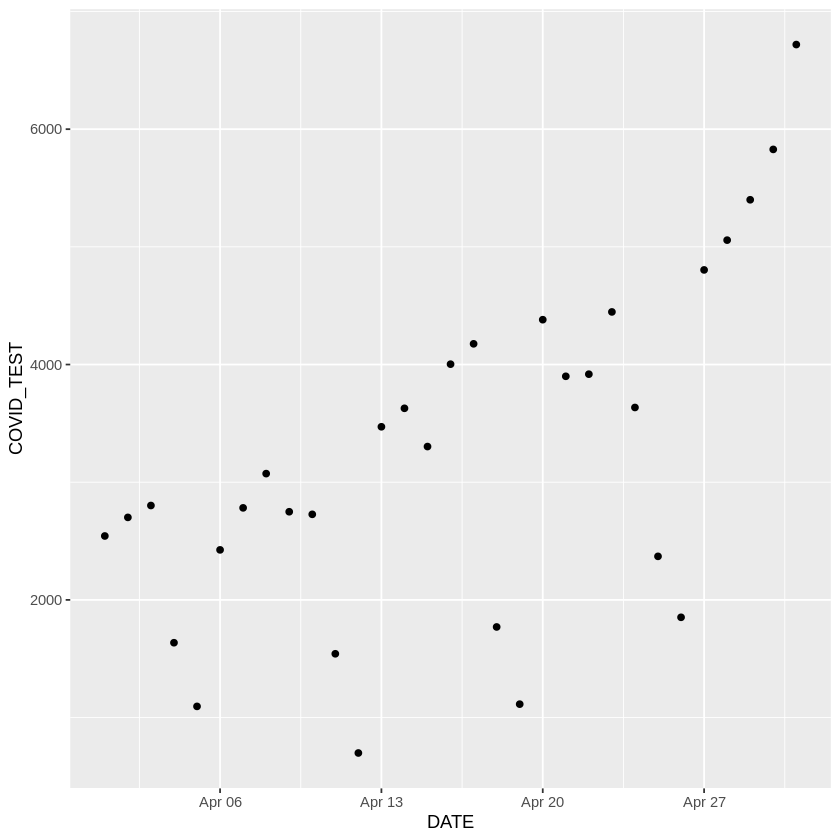

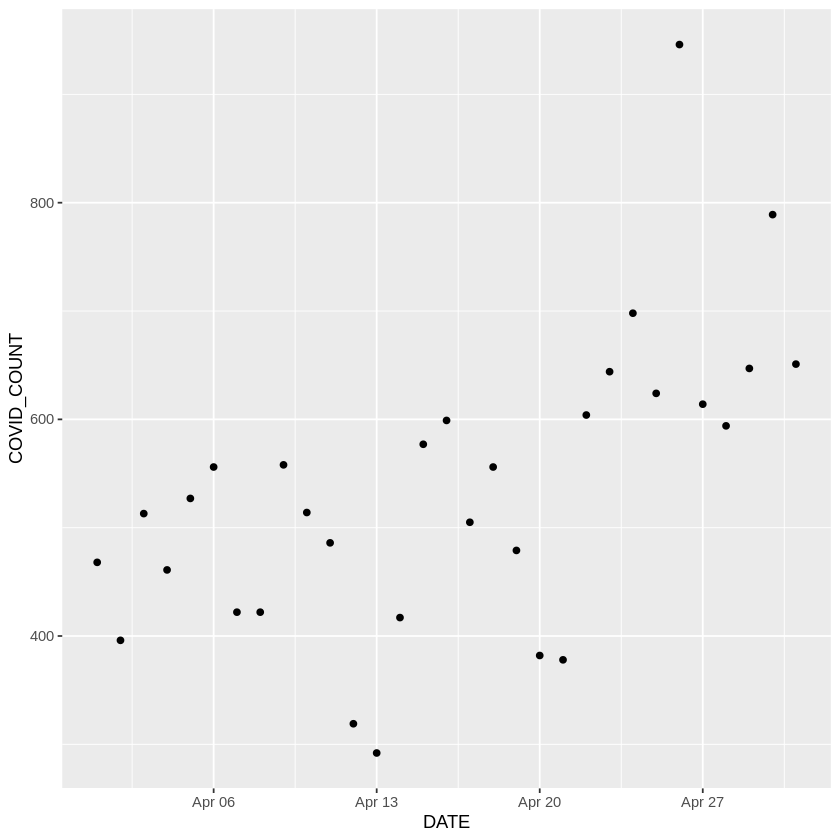

In [72]:
ggplot(table3, aes(DATE,COVID_TEST))+geom_point()
ggplot(table3, aes(DATE,COVID_COUNT))+geom_point()

> Now, since you have decided what data you want to model, you can pull them into memory, simply by using as_tibble or as.data.frame

In [ ]:
table4<-as_tibble(table3)

In [ ]:
class(table4)
nrow(table4) #and since it is a tibble now you can apply the function nrow() :)

> Great job! now you could start and you do not even need a single SQL command to get moving. 

## Section IV: Loading, understanding, and querying table using DBI and SQL statements
So what we will do: 
* Using the `dbSendQuery()` function in the DBI package 
    * to send SQL queries to load and understand the table (`SELECT()`, and `MIN()`,`MAX()`,`AVG()`, `COUNT()`) 
    * to query the table and selecting `DATE`,`COVID_TEST`, `COVID_COUNT` using `SELECT()` for the timeframe `2020-04-01` to `2020-05-01` using `WITH()`
    * to summarize the query with `MIN()`,`MAX()`,`AVG()`, `COUNT()` using a nested SQL statement
* Using the `dbGetQuery()` function in the DBI package to load the table into memory and plotting it with ggplot2

We can easily load, query and explore the table in BigQuery using the DBI package without directly bringing it into memory

In [ ]:
dbi_tb<-dbSendQuery(bq_conn,"SELECT * FROM covid19_tests_cases_deaths_IN")
head(dbFetch(dbi_tb),n=1)

In [ ]:
class(rs)

Notice that "rs” is of class 'BigQueryResult' and not a tibble. This is because dbSendQuery() and dbFetch() create a direct reference to the table in BigQuery but does NOT bring the data in-memory. This is particularly useful if you work with big data! 

In [ ]:
query<-"SELECT MIN(DATE) AS MIN_DATE ,MAX(DATE) AS MAX_DATE, AVG(COVID_TEST) AS AVG_TEST,AVG(COVID_COUNT) as AVG_COUNT,COUNT(DATE) AS NROWs FROM covid19_tests_cases_deaths_IN"
dbi_tb<-dbSendQuery(bq_conn,query)
dbFetch(dbi_tb)
class(dbi_tb)

In [ ]:
query2<-"SELECT DATE,COVID_TEST,COVID_COUNT FROM covid19_tests_cases_deaths_IN WHERE (DATE BETWEEN '2020-04-01' AND '2020-05-01')"
dbi_tb2<-dbSendQuery(bq_conn,query2)
head(dbFetch(dbi_tb2), n=6)

In [ ]:
query3<-"SELECT MIN(DATE) AS MIN_DATE, MAX(DATE) AS MAX_DATE,AVG(COVID_TEST) as mean_test, AVG(COVID_COUNT) as mean_cases,COUNT(DATE) as nrows FROM (SELECT DATE,COVID_TEST,COVID_COUNT FROM covid19_tests_cases_deaths_IN WHERE (DATE BETWEEN '2020-04-01' AND '2020-05-01'))"
dbi_tb3<-dbSendQuery(bq_conn,query3)
dbFetch(dbi_tb3)

In [ ]:
ggplot(dbi_tb2, aes(DATE,COVID_TEST))+geom_point()

> **NOTE**! You cannot use ggplot when you fetch with DBI direclty as the object class BIGQUERYRESULT is not recognized...So let's try something else!

In [ ]:
dbi_tb2b<-dbGetQuery(bq_conn,query2)
head(dbi_tb2b)
class(dbi_tb2b)

In [ ]:
ggplot(dbi_tb2b, aes(DATE,COVID_TEST))+geom_point()

> Great. We got this sorted. so with dbGetQuery you get a dataframe that you can manipulate! and plot! and to make this even more complicated I can also show you that it also works with the bq_project_query() from the BigRQuery package but....
> That's it for now and I am sure you can figure this out now! 